# Demo for reading GW binary data from memory

In [1]:
from lisainstrument import Instrument

# from lisagwresponse import GalacticBinary, Strain
from lisagwresponse import GalacticBinary

from lisaorbits import KeplerianOrbits

import pytdi

from pytdi.michelson import X2, Y2, Z2
from pytdi.ortho import A2, E2, T2
from pytdi.sagnac import ALPHA2, BETA2, GAMMA2,ZETA21, ZETA22, ZETA23
from pytdi.dsp import timeshift

In [2]:
pytdi.__version__

'1.1'

import sys
sys.path.append( '/Users/oliver jennrich/temp/gw-response')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Build an orbit

In [4]:
orbit = KeplerianOrbits()

Build a binary. The `GalacticBinary` class requires  either a file for the orbit or the x,y,z parameters to have dictionaries with the spacecraft coordinates. So we get the coordinates from the `compute_spacecraft_position()` method of `orbit` and the light travel time from `compute_light_travel_time()` and make and interplationg function for each of the coordinates per S/C.

In [5]:
from scipy.interpolate import interp1d

pos={}
x={}
y={}
z={}
tt={}

t = np.copy(orbit.t)
t = np.insert(t,0, t[0]-orbit.dt)
t = np.insert(t,-1, t[0]+orbit.dt)
for sc in orbit.SC_INDICES:
    pos[sc]=orbit.compute_spacecraft_position(sc,t)
    x[f'{sc}']=interp1d(t, pos[sc][:,0])
    y[f'{sc}']=interp1d(t,pos[sc][:,1])
    z[f'{sc}']=interp1d(t,pos[sc][:,2])
    

for links in orbit.LINK_INDICES:
    L = orbit.compute_light_travel_time(int(links[0]),int(links[1]),t)
    tt[links] = interp1d(t, L)

For some weird reasons (BUG?) the `orbit` parameter is mandatory, even though it is never used. So we just pass on an empty string. Plus, there are the usual edge problems with the time. 

In [6]:
size=2**12
gws = GalacticBinary(A=1e-20, f=3e-3, gw_beta=0, gw_lambda=0,x=x,y=y,z=z,tt=tt, orbits='',t0=t[1], size=size)

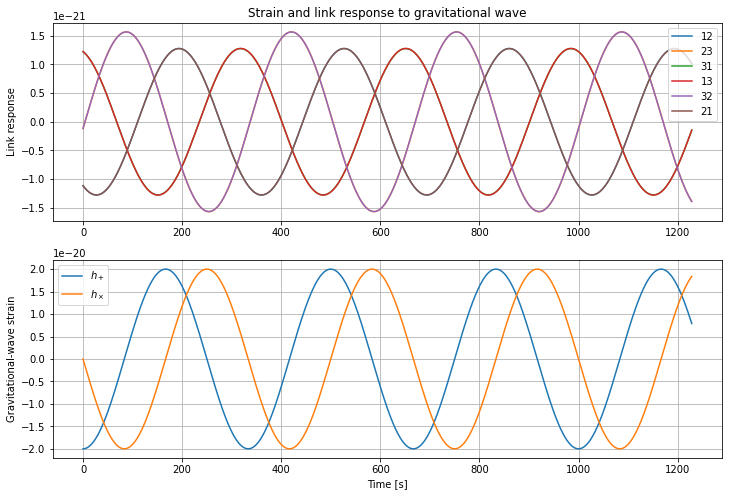

In [7]:
gws.plot()

Now we need to feed the orbits and the gravitational wave signal to the instrument. This is getting a bit convoluted, as the `Instrument` class *does* already accept an orbit represented not by a file but by an object in memory (via the `orbit_dataset` parameter), but it wants to see the light travel times directly. We calculate them above aready, so we can just use them here. 

The parameter `gws` also accepts a memory object, but it needs to recieve a dictionary with the links/mosa as key and an array of values as items. We use the `compute_gw_response` method to get the effect of the GW on the arms. As the method produces an 'array of arrays' we need to strip off the outher layer, hence the `[0]`.

A somewhat weird side-effect is that we need to create the response of the arms at the times given by the `physics_t` in the instrument (this is informed by the code in init_gws() in the instrument class). But we don't have an isntrument yet. So we create an 'empty' instrument without any GW signal but with the same `t0` and `size` and use its `physics_t` for the GW response calculation. We could also caluclate the times directly, but that would require more thinking (although the relevant code is in lines 227++ in the instrument class, but it needs other parameters known to the instrument so there is not much gained).


In [8]:
instrument0 = Instrument(orbit_dataset=L, t0=t[1], size=size)

gwsm = { links: gws.compute_gw_response(links,instrument0.physics_t)[0] for links in orbit.LINK_INDICES }
L = { links: orbit.compute_light_travel_time(int(links[0]),int(links[1]),instrument0.physics_t) for links in orbit.LINK_INDICES }

Now build the instrument with the parameters and simulate it so that we can plot the results.

In [9]:
instrument = Instrument(orbits=L, gws=gwsm, t0=t[1], size=size)
instrument.disable_all_noises()
instrument.simulate()

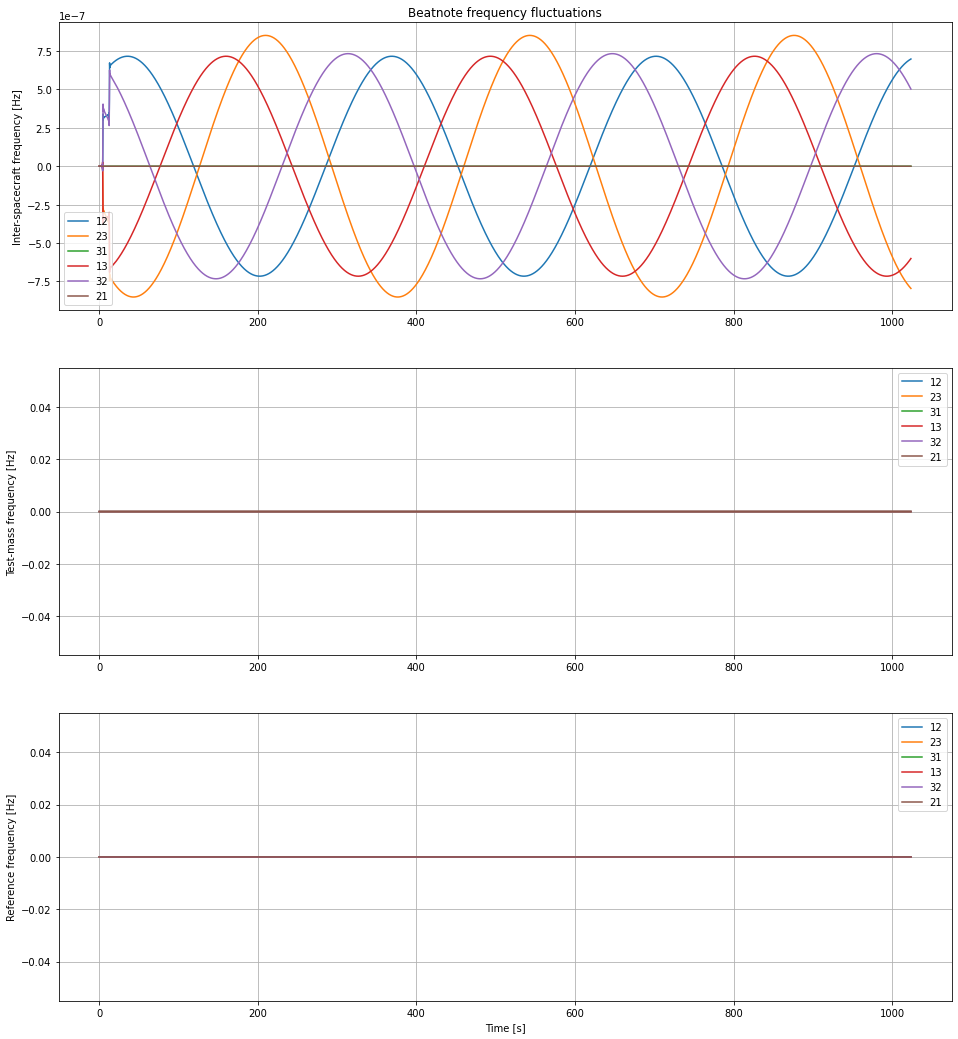

In [10]:
instrument.plot_fluctuations()

Ok, that worked. So the most practical thing is probably to make that into two derived classes, one for the galactic binaries that accept an orbit object out-of-the box and one for the instrument that accpets also the orbit and the GW signal without any additional effort.

In [11]:
class myGalacticBinary(GalacticBinary):
    def __init__(self, A,f,orbits, gw_beta=0, gw_lambda=0,t0=None,**kwargs):
        # make sure that the parent __init__ is called if orbit is a string
        if isinstance(orbit,str):
            super().__init__(A,f,orbits, gw_beta=gw_beta, gw_lambda=gw_lambda, **kwargs)
        else:
        # Create the auxilliary dictionaries that hold the interpolating functions:
            pos={}
            x={}
            y={}
            z={}
            tt={}

            # build a copy of the orbit times and extend it to the left and the right to make sure 
            # that the interpolation does not run out of range
            t = np.copy(orbits.t)
            if t0 == None:
                t0 = t[0]

            t = np.insert(t,0, t0-orbits.dt)
            t = np.insert(t,-1, t0+orbits.dt)

            # build the coordinate interpolators
            for sc in orbits.SC_INDICES:
                pos[sc]=orbits.compute_spacecraft_position(sc,t)
                x[f'{sc}']=interp1d(t, pos[sc][:,0])
                y[f'{sc}']=interp1d(t,pos[sc][:,1])
                z[f'{sc}']=interp1d(t,pos[sc][:,2])

            # build the light-travel times for the links
            for links in orbits.LINK_INDICES:
                L = orbits.compute_light_travel_time(int(links[0]),int(links[1]),t)
                tt[links] = interp1d(t, L)

            # now call the parent __init_ with the right parameters
            super().__init__(A, f, orbits='', gw_beta=gw_beta, gw_lambda=gw_lambda,
                             x=x,y=y,z=z,tt=tt, t0=t[1], **kwargs)
            
class myInstrument(Instrument):
    
    def __init__(self,  orbits='static',gws=None, 
                 t0='orbits',
                 physics_upsampling=4,
                 size=2592000, dt=1/4,
                 **kwargs):
        
                # the follwoing code needs to be copied, unfortunately
                # as it is not abstracted as a method
                if t0 == 'orbits':
                    self.t0=orbits.t[1]
                else:
                    self.t0 = t0

                
                # Physics sampling
                self.size = int(size)
                self.dt = float(dt)
                self.fs = 1 / self.dt

                self.physics_upsampling = int(physics_upsampling)
                self.physics_size = self.size * self.physics_upsampling
                self.physics_dt = self.dt / self.physics_upsampling
                self.physics_fs = self.fs * self.physics_upsampling
       
                self.physics_t = self.t0 + np.arange(self.physics_size, dtype=np.float64) * self.physics_dt
        
                # call the parent's init() if both orbits and gws are strings, otherwise
                # deal with it here
                if not isinstance(gws, str) and not isinstance(orbits, str):
                    # if only the orbit is a string, call the parent's init_orbit
                    if isinstance(orbits,str):
                        super().init_orbits(orbits, orbit_dataset)
                    else:
                        # so orbits is a memory structure. In this case we have to call the parent's init_orbit 
                        # with the correct orbits
                        self.orbits = { links: orbits.compute_light_travel_time(int(links[0]),int(links[1]),self.physics_t) for links in orbits.LINK_INDICES }

                    # if only gws is a string, call the parents init_gws() and then pass it on tho __init__
                    if isinstance(gws, str):
                        super().init_gws(gws)
                    else:
                        # so gws is *not* a string, so we assume it is an object
                        self.gws = { links: gws.compute_gw_response(links,self.physics_t)[0] for links in orbits.LINK_INDICES }


                    # now we can call the parent's init() with the correctly formatted arguments    
                    super().__init__(orbits=self.orbits, gws=self.gws,
                                     physics_upsampling=physics_upsampling,
                                     size=size, dt=dt,t0=self.t0,
                                     **kwargs)

                else:
                    super.__init__( orbits=orbits, gws=gws,
                                    physics_upsampling=physics_upsampling,
                                    size=size, dt=dt, t0=self.t0,
                                    **kwargs)
        

Now we can call the `myGalacticBinary` directly with the `orbit` as a parameter without writing it to file and the `myInstrument` with the same orbit parameter and the graviational wave signal also directly from a memory object.

In [12]:
orbit = KeplerianOrbits()
mygws = myGalacticBinary(1e-20, 1e-3, orbit, size=size)

myins = myInstrument( orbits=orbit, gws=mygws, size=size)

In [13]:
myins.disable_all_noises()
myins.simulate()

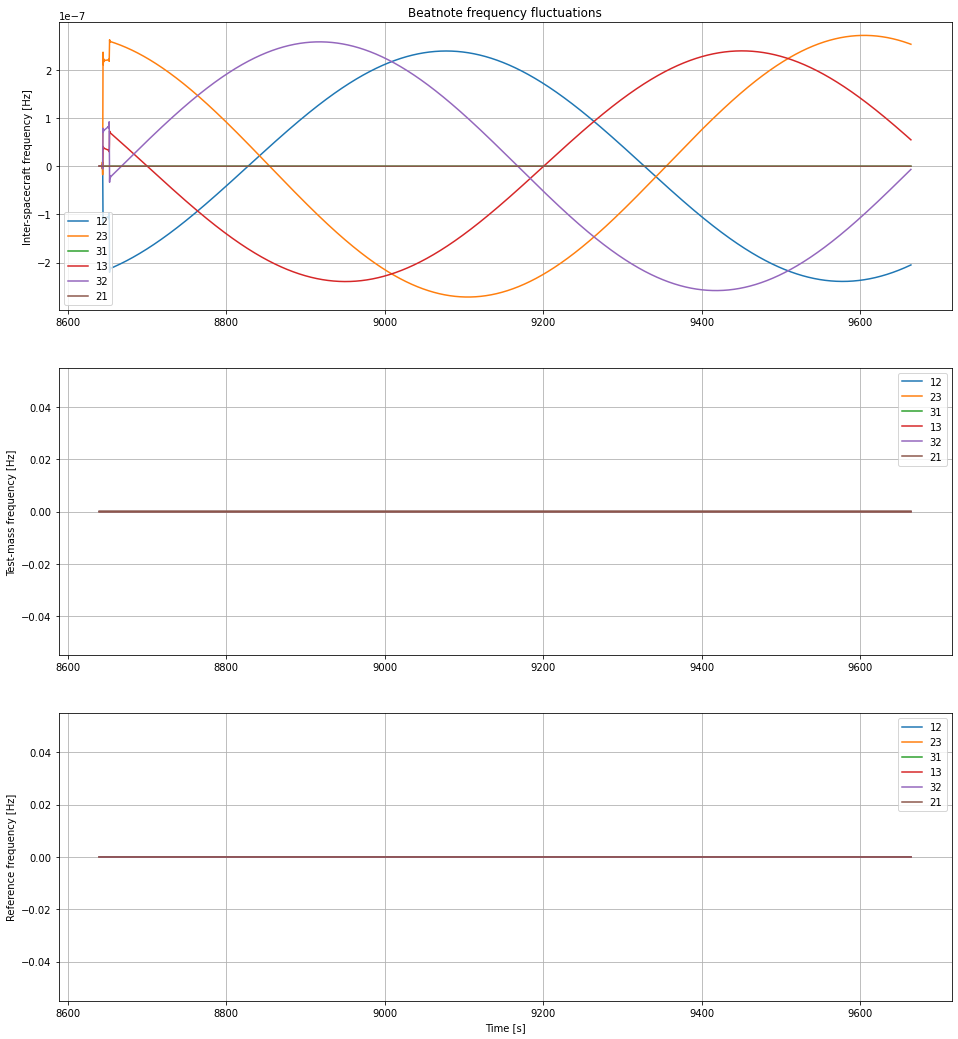

In [14]:
myins.plot_fluctuations()

Can we do the same with the Data class? And at that time also enable the acceptance of a interable (list, array,...) for the `gws` parameter so that we can add more than one signal?

In [15]:
class myData(pytdi.Data):
    
    # overload the 'from_gws' method
    @classmethod
    def from_gws(self, gws, orbits, skipped=0, orbit_dataset='tps/ppr', **kwargs):
        """
        gws: can be an object or a list of objects. If a filename is given, it behaves like the normal 'Data' class
        orbit: Acccpets an object as well as a file
        """

        # deal with the standard case
        if isinstance(gws, str):
            return super().from_gws(gws, orbits, **kwargs)
        
        # prepare the measurements under the assumption that gws is either an object or an iterable of an object
        
        try:
             _ = iter(gws)
        except TypeError as te:
            # if it isn't an iterable yet, make it so.
            gws=[gws]
            
        #now fill the new gws with the right values
        # assume that the first element in the listable gws 
        # has the values we want. We might want to make that
        # a parameter. Later.
        
        fs = gws[0].fs
        t0 = gws[0].t0
        
        t = gws[0].t
        
        # define and preset the measurements
        measurements = {}
        for mosa in self.MOSAS:
            measurements[f'isc_{mosa}'] = 0
            measurements[f'isc_sb_{mosa}'] =0 
            measurements[f'tm_{mosa}'] = 0
            measurements[f'ref_{mosa}'] = 0
            measurements[f'ref_sb_{mosa}'] = 0

        # run through the MOSAS and loop through the iterable
        # adding up the signals
        
        for mosa in self.MOSAS:
            for gws_s in gws:
                data = gws_s.compute_gw_response( mosa, t)[0]
                measurements[f'isc_{mosa}'] += super().slice(data, skipped)
                measurements[f'isc_sb_{mosa}'] += super().slice(data, skipped)
            
        # Load delays from orbit file
        return self.from_orbits(orbits, fs, t0, orbit_dataset, **measurements)
    
    
    # we also need to patch the from_orbits to allow an object to be passed
    @classmethod
    def from_orbits(self, orbits , fs, t0='orbits', dataset='tps/ppr', **kwargs):
        
        # Check if 'orbits' is a string - if so, pass it on the parent class' function
        if isinstance(orbits,str):
            return super().from_orbits(orbits, fs, t0=t0, dataset=dataset, **kwargs)
        
        # if not, assume orbits is an object and fill the parametrs accordingly
        
        # the next few lines are stolen from the parent's from_orbits
        # Check that we have at least one measurement
        if not kwargs:
            raise ValueError("from_orbits() requires at least one measurement")
        # Check that keywords are valid measurements
        size = 0
        for key, arg in kwargs.items():
            if isinstance(arg, (int, float)):
                size = max(size, 1)
            else:
                size = max(size, len(arg))
            if key not in self.MEASUREMENTS:
                raise TypeError(f"from_orbits() has invalid measurement key '{key}'")
                
        if t0=='orbits':
            t0 = orbits.t0
            
        t = t0 + np.arange(size) / fs
        
        delays={}
        for i, mosa in enumerate(self.MOSAS):
            delays[f'd_{mosa}'] = orbits.compute_light_travel_time(int(mosa[0]), int(mosa[1]),t)
            
        # Create measurements dictionary
        measurements = {key: kwargs.get(key, 0) for key in self.MEASUREMENTS}
        # Create instance
        data = self(measurements, delays, fs)
        data.compute_delay_derivatives()
        return data

Testdrive the system - add a few galactic binaries to see if new class accepts a list of GWS

In [16]:
mygws_a = myGalacticBinary(2e-20, 7e-3, orbit, gw_beta = np.pi/2, size=size)
mygws_b = myGalacticBinary(0.5e-20, 19e-3, orbit, gw_beta = np.pi/7, size=size)

Write the three signals into a file so that we can compare it with the new 'iterable' approach

In [17]:
mygws.write('Data/gal_bin.h5')
mygws_a = myGalacticBinary(2e-20, 7e-3, orbit, gw_beta = np.pi/2, size=size)
mygws_a.write('Data/gal_bin.h5')
mygws_b.write('Data/gal_bin.h5')

mygws.write('Data/gal_bin_s.h5')

Build two data sets, one from the list of signal objects, one from the file

In [18]:
mydata= myData.from_gws( [mygws, mygws_a, mygws_b], orbit )
mydata_ff = myData.from_gws( 'Data/gal_bin.h5', orbit )

In [19]:
for ((k,v), (k_ff, v_ff)) in zip( mydata.measurements.items(), mydata_ff.measurements.items() ):
    # plt.plot(v-v_ff)
    # plt.show()
    if not np.sum( (v-v_ff)**2 )==0:
        raise f"Problem found in measurement {k}"

TypeError: exceptions must derive from BaseException

In [20]:
mydata= myData.from_gws( mygws, orbit )
mydata_ff = myData.from_gws( 'Data/gal_bin_s.h5', orbit )

In [21]:
for ((k,v), (k_ff, v_ff)) in zip( mydata.measurements.items(), mydata_ff.measurements.items() ):
    if not np.sum( (v-v_ff)**2 )==0:
        raise f"Problem found in measurement {k}"

TypeError: exceptions must derive from BaseException

All cool, apparently - both methods give the same results. 

In [22]:
print (mydata.measurements)

{'isc_12': array([-3.85585068e-22, -3.85922463e-22, -3.86258486e-22, ...,
       -2.30865742e-22, -2.30192180e-22, -2.29517800e-22]), 'isc_23': array([-1.29775574e-23, -1.19943552e-23, -1.10111103e-23, ...,
        5.14783791e-22,  5.14942779e-22,  5.15099938e-22]), 'isc_31': array([ 3.97541842e-22,  3.97256692e-22,  3.96970131e-22, ...,
       -9.45630687e-23, -9.53444330e-23, -9.61254585e-23]), 'isc_13': array([ 3.97604928e-22,  3.97319415e-22,  3.97032491e-22, ...,
       -9.47422478e-23, -9.55237787e-23, -9.63049701e-23]), 'isc_32': array([-1.29722998e-23, -1.19892923e-23, -1.10062422e-23, ...,
        5.14682245e-22,  5.14841197e-22,  5.14998319e-22]), 'isc_21': array([-3.85480593e-22, -3.85818228e-22, -3.86154491e-22, ...,
       -2.30974876e-22, -2.30301541e-22, -2.29627388e-22]), 'tm_12': 0, 'tm_23': 0, 'tm_31': 0, 'tm_13': 0, 'tm_32': 0, 'tm_21': 0, 'ref_12': 0, 'ref_23': 0, 'ref_31': 0, 'ref_13': 0, 'ref_32': 0, 'ref_21': 0, 'isc_sb_12': array([-3.85585068e-22, -3.85922463e-2

In [23]:
discard = 300
def A(d):
    return A2.build(**d.args)(d.measurements)[discard:]
def E(d):
    return E2.build(**d.args)(d.measurements)[discard:]
def T(d):
    return T2.build(**d.args)(d.measurements)[discard:]


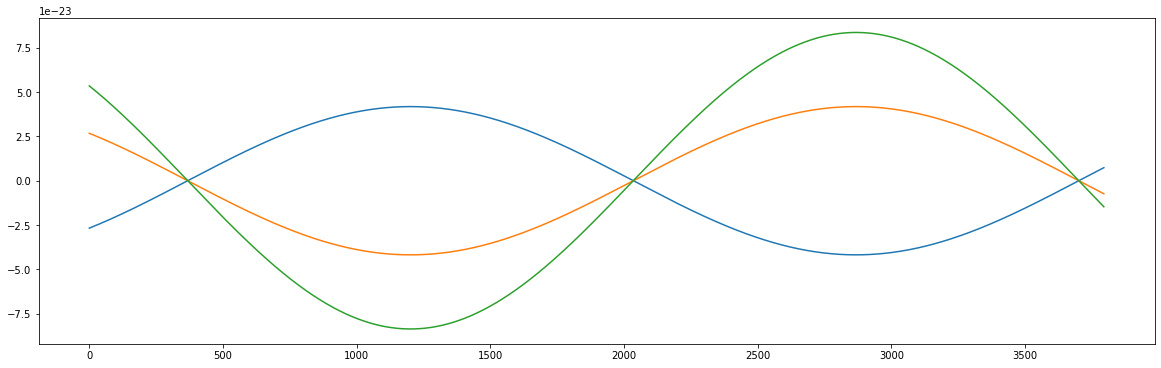

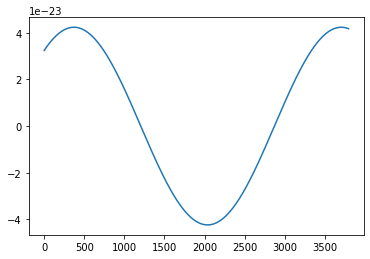

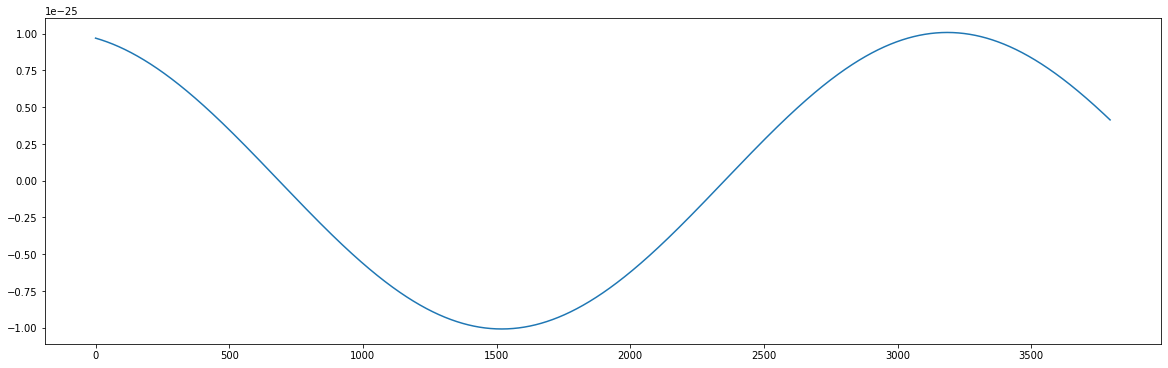

In [26]:
plt.figure(figsize=(20,6))
plt.plot(A(mydata)-A(mydata_ff))
plt.plot(A(mydata))
plt.plot(A(mydata_ff))
plt.show()
plt.plot(E(mydata)-E(mydata_ff))
plt.show()
plt.figure(figsize=(20,6))
plt.plot(T(mydata)-T(mydata_ff))
plt.show()